# Breast Cancer Research Project EDA

## Introduction

## Imports

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [3]:
# Load Metadata
data_path = '/content/drive/My Drive/Breast_Cancer_Detection/Data/'

df_metadata_train = pd.read_csv(data_path + "train_metadata.csv")
df_metadata_test = pd.read_csv(data_path + "test_metadata.csv")

print('Training Metadata Shape: ' + str(df_metadata_train.shape))
print('Testing Metadata Shape: ' + str(df_metadata_test.shape) + '\n')
print(df_metadata_train.head(10))

Training Metadata Shape: (344, 3)
Testing Metadata Shape: (149, 3)

    Sample ID Patient ID Center ID
0  ID_001.npy      P_001       C_1
1  ID_002.npy      P_002       C_2
2  ID_005.npy      P_005       C_5
3  ID_006.npy      P_006       C_5
4  ID_007.npy      P_007       C_2
5  ID_012.npy      P_012       C_1
6  ID_013.npy      P_013       C_2
7  ID_014.npy      P_014       C_5
8  ID_016.npy      P_016       C_1
9  ID_018.npy      P_018       C_2


The metadata is for each sample and includes patient ID and the center ID.
Also note that we have 344 training samples and 149 test samples.

In [4]:
# Load Training Targets
df_output_train = pd.read_csv(data_path + "train_output.csv")

# Merge Metadata and Targets for training data
df_metadata_y_train = df_metadata_train.merge(df_output_train, on="Sample ID")

In [5]:
# Load Training Data
X_train = []
y_train = []
centers_train = []
patients_train = []
zoom_train = []
coordinates_train = []


for sample, label, center, patient in tqdm(df_metadata_y_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values):

    # Load the coordinates and features (1000, 3+2048)
    all_features = np.load(data_path + 'train/moco_features/' + sample)

    # Check each sample has 1000 tiles
    num_tiles = len(all_features)
    if num_tiles != 1000:
        print("Error: Sample does not have exactly 1000 tiles. This will cause errors.")

    # Remove the coordinates and zoom from MoCo features
    features = all_features[:, 3:]
    # Store zoom for each sample
    zoom = all_features[:, 0]
    # Store coordinates for each sample
    coordinates = all_features[:, 1:3]

    # Store all the data for each sample in 1 row (this will be reshaped back later)
    X_train.append(features.flatten())

    # Store data label and other metadata
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)
    zoom_train.append(zoom.flatten())
    coordinates_train.append(coordinates.flatten())

# Convert to numpy arrays
X_train = np.array(X_train).astype(np.float16) # float32 too big for laptop memory
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)
zoom_train = np.array(zoom_train)
coordinates_train = np.array(coordinates_train)

# Save shape of features for reshaping X_train
feat_shape = np.shape(features)


100%|██████████| 344/344 [03:31<00:00,  1.63it/s]


The training set comprises of 344 images. These images are extremely large, so 1000 tiles in each were selected to reduce dimensionality. From each tile, 2048 MoCo features were extracted to further reduce dimensionality.

In the training set, we have 344 Numpy array with each array storing the MoCo features from each image. Each Numpy array has 1000 rows, each row represents a snippet from the sample image, and 2051 columns, 2048 columns store MoCo features and 3 columns store the zoom and coordinates of the snippet.

In the cell above, we seperate the training data into arrays of:
- X_train : MoCo features only
- y_train : if the snippet is part of image with cancer (0 or 1)
- centers_train : metadata about where the sample was taken
- patients_train : metadata about who the sample was taken from
- zoom_train : metadata about the zoom of the snippet
- coordinates_train : metadata about where the snippet was located in the image

In [6]:
# Load Testing Data

X_test = []
centers_test = []
patients_test = []
zoom_test = []
coordinates_test = []

# Process test data (remove coordintes and flatten each sample into a row)
for sample, center, patient in tqdm(df_metadata_test[["Sample ID", "Center ID", "Patient ID"]].values):

    all_features = np.load(data_path + 'test/moco_features/' + sample)

    features = all_features[:, 3:]
    zoom = all_features[:, 0]
    coordinates = all_features[:, 1:3]
    X_test.append(features.flatten())

    centers_test.append(center)
    patients_test.append(patient)
    zoom_test.append(zoom.flatten())
    coordinates_test.append(coordinates.flatten())


X_test = np.array(X_test).astype(np.float16)
centers_test = np.array(centers_test)
patients_test = np.array(patients_test)
zoom_test = np.array(zoom_test)
coordinates_test = np.array(coordinates_test)

100%|██████████| 149/149 [01:29<00:00,  1.66it/s]


A similar process has been taken to prepare the test data as was done with the training data. As this dataset was taken from an online challenge (https://challengedata.ens.fr/participants/challenges/98/), the test targets are not available. However, model outputs will be upload to the challenges submission page and the performance measured.

## EDA

### Class Distribution

In [7]:
# Class Distribution

count_postive_cases = np.count_nonzero(y_train == 1)
count_negative_cases = np.count_nonzero(y_train == 0)

print("Fraction with cancer: " + str(round(100*count_postive_cases / (count_postive_cases+count_negative_cases), 2)) + "%" )
print("Fraction without cancer: " + str(round(100*count_negative_cases / (count_postive_cases+count_negative_cases), 2)) + "%" )

Fraction with cancer: 37.21%
Fraction without cancer: 62.79%


The class distribution is sufficiently imbalanced such that a stratefied data split is necessary.

### Center Patterns

In [8]:
# Investigate centers

unique_centers_train = np.unique(centers_train)
num_unique_centers_train = len(unique_centers_train)

print("Number of unique centers in traing data:", num_unique_centers_train)
print("Unique centers:", unique_centers_train , '\n')

unique_centers_test = np.unique(centers_test)
num_unique_centers_test = len(unique_centers_test)

print("Number of unique centers in testing center:", num_unique_centers_test)
print("Unique centers:", unique_centers_test)

Number of unique centers in traing data: 3
Unique centers: ['C_1' 'C_2' 'C_5'] 

Number of unique centers in testing center: 2
Unique centers: ['C_3' 'C_4']


As the test centers differ from the centers in the training set, it will be important to ensure that model does not overfit on information regarding the center.

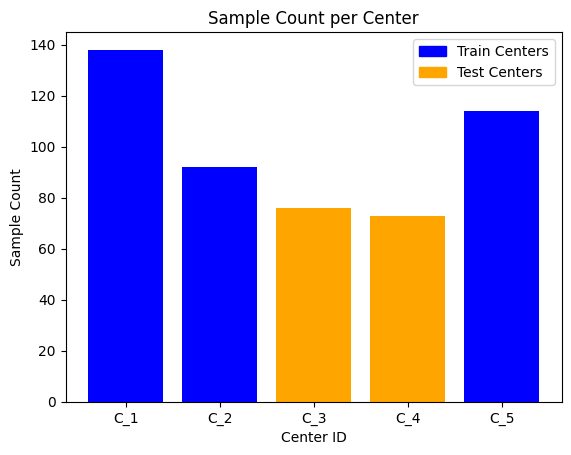

In [9]:
# Merge centers_train and centers_test
all_centers = np.concatenate([centers_train, centers_test])

# Count the occurrences of each center
unique_centers, center_counts = np.unique(all_centers, return_counts=True)

# Define colors for train and test centers
colors = ['blue' if center_id in centers_train else 'orange' for center_id in unique_centers]

# Create a bar plot with legend
bars = plt.bar(unique_centers, center_counts, color=colors)
plt.xlabel('Center ID')
plt.ylabel('Sample Count')
plt.title('Sample Count per Center')
legend_labels = ['Train Centers', 'Test Centers']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color='blue'), plt.Rectangle((0, 0), 1, 1, color='orange')]
plt.legend(legend_handles, legend_labels)
plt.xticks(unique_centers)
plt.show()

As the number of patients per centre in the training set is fairly similar, a random split of samples from these centers should be sufficient (in other words a startified split is not necessary).

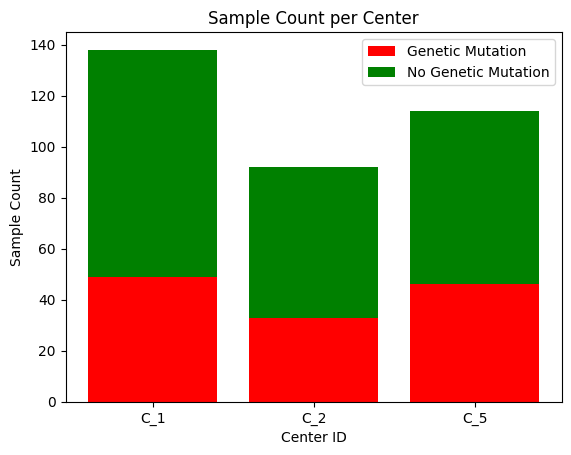

In [10]:
# Merge y_train and centers_train as two columns
centers_labels = np.column_stack((y_train, centers_train))

# Create a stacked bar plot with legend
unique_centers, center_counts = np.unique(centers_train, return_counts=True)

# Initialize lists to store positive and negative counts per center
center_positive_counts = []
center_negative_counts = []

for center_id in unique_centers:
    positive_count = np.sum((centers_labels[:, 0] == '1') & (centers_labels[:, 1] == center_id))
    negative_count = np.sum((centers_labels[:, 0] == '0') & (centers_labels[:, 1] == center_id))
    center_positive_counts.append(positive_count)
    center_negative_counts.append(negative_count)

# Define colors for positive and negative cases
colors = ['green', 'red']

# Create a bar plot for positive cases
plt.bar(unique_centers, center_positive_counts, color=colors[1], label='Genetic Mutation')
# Create a bar plot for negative cases, stacked on top of positive cases
plt.bar(unique_centers, center_negative_counts, bottom=center_positive_counts, color=colors[0], label='No Genetic Mutation')

plt.xlabel('Center ID')
plt.ylabel('Sample Count')
plt.title('Sample Count per Center')
plt.legend()
plt.xticks(unique_centers)
plt.show()

The distribution of cancer cases across centers is fairly consistent (roughly 40-60), which again indicates that a random split across centers is sufficient.

### Patient Patterns

In [11]:
# Count the occurrences of each patient
unique_patients, patient_counts = np.unique(patients_train, return_counts=True)

print("Total number of samples: ", len(y_train))
print("Total number of patients: ", len(unique_patients))

Total number of samples:  344
Total number of patients:  305


Some patients have multiple samples. Let's analyze these patients with multiple samples

In [12]:
# Count the occurrences of each count value
count_occurrences = np.bincount(patient_counts)

# Iterate through counts and print patients
for count, occurrences in enumerate(count_occurrences):
    if count > 1:
        print(f'Patients with {count} samples: {occurrences}')

Patients with 2 samples: 37
Patients with 3 samples: 1


Most patient with multiple samples only have 2 samples.

In [13]:
# Combine patient_ids and y_train into a 2D array
patient_label = np.column_stack((patients_train, y_train))

# Initialize counters
label_0_twice = 0
label_1_twice = 0
label_0_1 = 0

# Iterate through unique patient_ids
for patient_id in unique_patients:
    # Get the rows corresponding to the current patient_id
    rows = patient_label[patient_label[:, 0] == patient_id]

    # Update counters based on label occurrences
    if len(rows) == 2:

        if np.all(rows[:, 1] == '0'):
            label_0_twice += 1

        elif np.all(rows[:, 1] == '1'):
            label_1_twice += 1

        else:
            label_0_1 += 1

    if len(rows) == 3:
        print(f'Labels for patient with 3 samples: {rows[:, 1]} \n')

print('Patients with 2 samples:')
print(f"Label 0 twice: {label_0_twice} patients")
print(f"Label 1 twice: {label_1_twice} patients")
print(f"Label 0 and 1: {label_0_1} patients")

Labels for patient with 3 samples: ['1' '1' '1'] 

Patients with 2 samples:
Label 0 twice: 23 patients
Label 1 twice: 14 patients
Label 0 and 1: 0 patients


All patients with multiple samples have the same label for each sample. While one option would be to randomly drop samples from each of these patients, so that the model does not overfit for each patient as each patient only has one sample, I think it is wise to keep all samples from these patients as the dataset is fairly small and these samples could be viewed as augmented data.

### Zoom Patterns

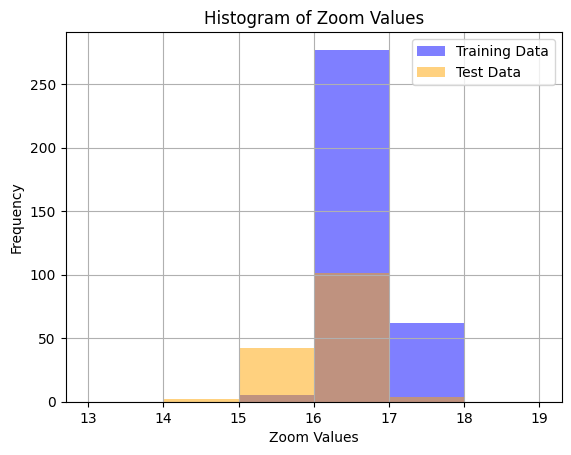

In [14]:
# Flatten the 1D array
zoom_train_flat = zoom_train.flatten()
zoom_test_flat = zoom_test.flatten()

# Create a histogram for training data
plt.hist(zoom_train_flat, bins=np.arange(13, 20, 1), color='blue', alpha=0.5, label='Training Data')
plt.xlabel('Zoom Values')
plt.ylabel('Frequency')
plt.title('Histogram of Zoom Values')
plt.grid(True)

# Get the current y-axis ticks and labels
y_ticks, y_tick_labels = plt.yticks()
new_y_tick_labels = [str(int(float(label.get_text()) / 1000)) for label in y_tick_labels]
plt.yticks(y_ticks, new_y_tick_labels)

# Plot the histogram for test data on top in orange
plt.hist(zoom_test_flat, bins=np.arange(13, 20, 1), color='orange', alpha=0.5, label='Test Data')
plt.legend()

# Show the histogram
plt.show()

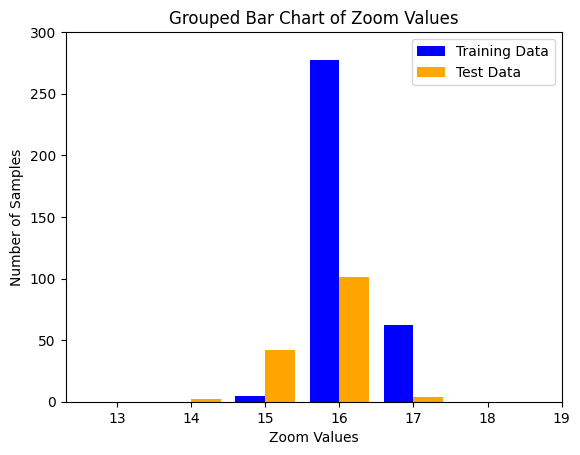

In [15]:
# Set the bin edges
bin_edges = np.arange(13, 20, 1)

# Calculate histograms for training and test data
hist_train, _ = np.histogram(zoom_train_flat, bins=bin_edges)
hist_test, _ = np.histogram(zoom_test_flat, bins=bin_edges)

# Set the width of the bars (adjust as needed)
bar_width = 0.4

# Set the positions for the bars
x_train = bin_edges[:-1] - bar_width / 2
x_test = bin_edges[:-1] + bar_width / 2

# Create the grouped bar chart
plt.bar(x_train, hist_train, width=bar_width, color='blue', label='Training Data')
plt.bar(x_test, hist_test, width=bar_width, color='orange', label='Test Data')

# Customize the plot
plt.xlabel('Zoom Values')
plt.ylabel('Number of Samples')
plt.title('Grouped Bar Chart of Zoom Values')

# Get the current y-axis ticks and labels
y_ticks, y_tick_labels = plt.yticks()
new_y_tick_labels = [str(int(float(label.get_text()) / 1000)) for label in y_tick_labels]
plt.yticks(y_ticks, new_y_tick_labels)

# Set the x-axis ticks to match the bin edges
plt.xticks(bin_edges)

# Add a legend
plt.legend()

# Show the grouped bar chart
plt.show()

In the training and test sets most zooms tend to be 16 (histograms in matplotlib are left inclusive and zoom levels are integers). However, the test set has disproportionatley more samples with zoom 15 than the test does, and conversely the train set has disproportionatley more samples at zoom 17 than the test set. Moreover, the test set has a sample with zoom 14, which the training set does not have.

I assume that samples are taken at multiple zooms, therefore, there is no need to do a stratified split based on zoom level.

Note: maybe look into training the network at 1 zoom level?

### MoCo Feature Patterns

There are 2048 MoCo features, which makes it hard to visualize and explore. For now we will omit exploration of these features, however, we may return to them to look at:
- Dimensionality Reduction (eg. PCA)
- Correlations with target variable
- Clustering

### Coordinate Patterns

I would hypothesize that snippets indicating the presence of cancer are localized (that is close together). While individual snippets are unlabeled, we could measure patterns of how 'co-locatedness' of snippets in samples with and without cancer. If there is a pattern, we could work on incorporating it into the model. An example of this would be add a node in the MLP quantifying 'co-locatedness' of the top instances (this idea will become clearer as we continue).

## EDA Conclusions:

- Stratified split based on class distribution is necessary due to the imbalance
- Patients and class disribution is fairly evenly split across centers
- Most patients have 1 sample, but the patients with multiple samples have the same label for all their samples
- We will include all samples from each patient (may need to reconsider this decision)
- Snippets are taken at different zooms (most being at 15). We will use snippets from all zooms, but it may be better to train the model on snippets from 1 zoom
- MoCo features have too many dimensions for initial EDA, but we may revisit their patterns later
- Coordinate patterns are difficult to measure, but we may revisit their patterns later